<a href="https://colab.research.google.com/github/NismaK/ML-Knee-Osteoarthritis-Classification/blob/main/Gaitdatasetfeatureextraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🦵 Gait Feature Extraction


### Environment Setupgs("ignore", category=UserWarning)



In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install opencv-python mediapipe numpy pandas scipy tqdm


### 🎥 Load and List Video Files from Folders

In [ ]:
import os, cv2, math, json, glob
import numpy as np, pandas as pd
from tqdm import tqdm
from scipy.signal import find_peaks
import mediapipe as mp

ROOT_DIR = "/content/drive/MyDrive/KOA-PD-NM/KOA"
OUTPUT_CSV = "/content/drive/MyDrive/KOA-PD-NM/results.csv"

mp_pose = mp.solutions.pose


In [ ]:
import glob, os

ROOT_DIR = "/content/drive/MyDrive/KOA-PD-NM/KOA"

for sub in ["KOA_EL","KOA_MD","KOA_SV","KOA_NM"]:
    folder = os.path.join(ROOT_DIR, sub)
    vids = glob.glob(os.path.join(folder, "*.MOV"))  # ✅ looks for videos inside the subfolder
    print(f"{sub}: found {len(vids)} videos")



KOA_EL: found 30 videos
KOA_MD: found 40 videos
KOA_SV: found 30 videos
KOA_NM: found 60 videos


In [ ]:
def angle_between_vectors(a, b):
    a,b = np.array(a), np.array(b)
    if np.linalg.norm(a)==0 or np.linalg.norm(b)==0: return np.nan
    cosv = np.clip(np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b)),-1,1)
    return math.degrees(math.acos(cosv))

def compute_knee_angle(hip,knee,ankle):  return 180 - angle_between_vectors(hip-knee, ankle-knee)
def compute_hip_angle(sh,hip,knee):      return 180 - angle_between_vectors(sh-hip, knee-hip)
def compute_ankle_angle(knee,ankle,foot):return 180 - angle_between_vectors(knee-ankle, foot-ankle)

def estimate_cadence_and_stride(sig,fps):
    if len(sig)<3: return np.nan,np.nan
    filt=np.convolve(sig,np.ones(5)/5,mode='same')
    peaks,_=find_peaks(filt,distance=int(0.3*fps))
    troughs,_=find_peaks(-filt,distance=int(0.3*fps))
    events=np.sort(np.concatenate([peaks,troughs]))
    if len(events)<2: return np.nan,np.nan
    step_time=np.diff(events)/fps
    cadence=60/np.nanmean(step_time) if len(step_time)>0 else np.nan
    if len(peaks)>1:
        stride_len=np.nanmedian(np.abs(sig[peaks[1:]]-sig[peaks[:-1]]))*2
    else:
        stride_len=np.nan
    return cadence,stride_len


In [ ]:
def process_video(path,pose):
    cap=cv2.VideoCapture(path)
    fps=cap.get(cv2.CAP_PROP_FPS) or 30
    w=int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)); h=int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    data={'knee':[],'hip':[],'ankle':[],'ankle_x':[]}
    while True:
        ret,frame=cap.read()
        if not ret: break
        res=pose.process(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
        if not res.pose_landmarks:
            [data[k].append(np.nan) for k in data]; continue
        lm=res.pose_landmarks.landmark
        def L(name):
            p=mp_pose.PoseLandmark[name]; return np.array([lm[p].x*w,lm[p].y*h])
        try:
            shl,hipl,knl,anl,fll=L('LEFT_SHOULDER'),L('LEFT_HIP'),L('LEFT_KNEE'),L('LEFT_ANKLE'),L('LEFT_FOOT_INDEX')
            shr,hipr,knr,anr,flr=L('RIGHT_SHOULDER'),L('RIGHT_HIP'),L('RIGHT_KNEE'),L('RIGHT_ANKLE'),L('RIGHT_FOOT_INDEX')
            knee=np.nanmean([compute_knee_angle(hipl,knl,anl),compute_knee_angle(hipr,knr,anr)])
            hip =np.nanmean([compute_hip_angle(shl,hipl,knl),compute_hip_angle(shr,hipr,knr)])
            ank =np.nanmean([compute_ankle_angle(knl,anl,fll),compute_ankle_angle(knr,anr,flr)])
            ax =np.nanmean([anl[0],anr[0]])
        except: knee,hip,ank,ax=[np.nan]*4
        data['knee'].append(knee); data['hip'].append(hip); data['ankle'].append(ank); data['ankle_x'].append(ax)
    cap.release()
    arr=lambda k:np.nanmean(data[k]) if data[k] else np.nan
    cadence,stride=estimate_cadence_and_stride(np.array(data['ankle_x']),fps)
    return arr('knee'),arr('hip'),arr('ankle'),cadence,stride


In [ ]:
results=[]
with mp_pose.Pose(static_image_mode=False,min_detection_confidence=0.5,min_tracking_confidence=0.5) as pose:
    for sub in ["KOA_EL","KOA_MD","KOA_SV","KOA_NM"]:
        folder=os.path.join(ROOT_DIR,sub)
        vids=glob.glob(os.path.join(folder,"*.MOV"))
        for v in tqdm(vids,desc=sub):
            k,h,a,c,s=process_video(v,pose)
            results.append({
                "video":os.path.basename(v),
                "class":sub,
                "knee_flexion_angle_deg":k,
                "hip_extension_angle_deg":h,
                "ankle_dorsiflexion_deg":a,
                "cadence_steps_per_minute":c,
                "stride_length":s
            })

df=pd.DataFrame(results)
df.to_csv(OUTPUT_CSV,index=False)
print("✅ Saved:",OUTPUT_CSV)
df.head()


KOA_EL:   0%|          | 0/30 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
KOA_NM: 100%|██████████| 60/60 [09:44<00:00,  9.75s/it]

✅ Saved: /content/drive/MyDrive/KOA-PD-NM/results.csv


,video,class,knee_flexion_angle_deg,hip_extension_angle_deg,ankle_dorsiflexion_deg,cadence_steps_per_minute,stride_length
0,001_KOA_01_EL.MOV,KOA_EL,13.953616,9.218049,63.090237,116.883117,792.774639
1,001_KOA_02_EL.MOV,KOA_EL,12.859532,6.395187,66.224687,41.666667,2308.612761
2,002_KOA_01_EL.MOV,KOA_EL,21.399918,16.166533,69.990770,92.307692,822.932281
3,003_KOA_01_EL.MOV,KOA_EL,16.275851,12.834254,63.734158,123.529412,558.745022
4,003_KOA_02_EL.MOV,KOA_EL,19.114508,25.370629,59.730863,62.240664,1607.646096


# **Sample**

1️⃣ Imports

In [ ]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import numpy as np


2️⃣ Initialize MediaPipe

In [ ]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

3️⃣ Function to show a pose snapshot

In [ ]:
def show_pose_snapshot(video_path, frame_number=None):
    """
    Displays a single frame from the video with pose skeleton overlaid.

    Parameters:
    - video_path : str : path to the video file
    - frame_number : int : which frame to pick (default = middle frame)
    """
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if frame_number is None:
        frame_number = total_frames // 2  # middle frame

    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    if not ret:
        print("Could not read the frame.")
        cap.release()
        return

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    with mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5) as pose:
        result = pose.process(frame_rgb)
        if result.pose_landmarks:
            mp_drawing.draw_landmarks(frame_rgb, result.pose_landmarks, mp_pose.POSE_CONNECTIONS)

    plt.figure(figsize=(8,8))
    plt.imshow(frame_rgb)
    plt.axis('off')
    plt.title(f"Pose Snapshot: Frame {frame_number}")
    plt.show()

    cap.release()


4️⃣ Running on a sample video

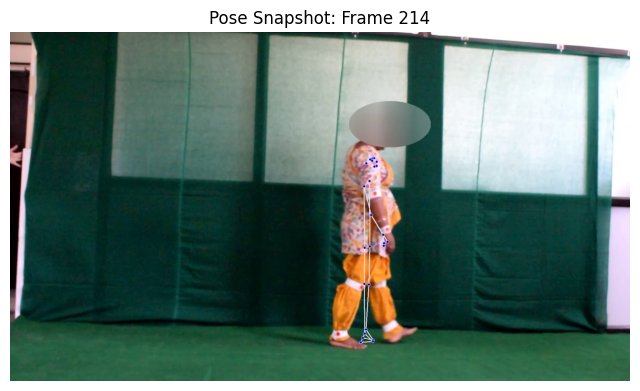

In [ ]:
sample_video = "/content/drive/MyDrive/KOA-PD-NM/KOA/KOA_EL/001_KOA_01_EL.MOV"
show_pose_snapshot(sample_video)
